In [4]:
import pandas as pd
import numpy as np
import sqlite3
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

plt.style.use("seaborn-v0_8")


In [5]:
db_path = "data_quality_monitor.db"
conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.executescript("""
PRAGMA foreign_keys = ON;

CREATE TABLE IF NOT EXISTS datasets (
    dataset_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    source TEXT,
    created_at TEXT DEFAULT CURRENT_TIMESTAMP
);

CREATE TABLE IF NOT EXISTS raw_data (
    row_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    row_json TEXT NOT NULL,
    FOREIGN KEY(dataset_id) REFERENCES datasets(dataset_id)
);

CREATE TABLE IF NOT EXISTS cleaned_data (
    row_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    row_json TEXT NOT NULL,
    FOREIGN KEY(dataset_id) REFERENCES datasets(dataset_id)
);

CREATE TABLE IF NOT EXISTS quality_checks (
    check_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    column_name TEXT,
    check_type TEXT,
    metric_name TEXT,
    metric_value TEXT,
    FOREIGN KEY(dataset_id) REFERENCES datasets(dataset_id)
);

CREATE TABLE IF NOT EXISTS anomaly_scores (
    anomaly_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    row_index INTEGER,
    anomaly_score REAL,
    is_anomaly INTEGER,
    model_name TEXT,
    FOREIGN KEY(dataset_id) REFERENCES datasets(dataset_id)
);

CREATE TABLE IF NOT EXISTS logs (
    log_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER,
    action TEXT,
    details TEXT
);
""")

conn.commit()
print("Database initialized.")


Database initialized.


In [6]:
df = pd.read_csv("aggregated_nyc_yellow_taxi_2024.csv")
df.head()


,date,hour,passenger_count,PU_Borough,DO_Borough,payment_type,trip_count,trip_distance_sum,duration_sum,fare_amount_sum,extra_sum,mta_tax_sum,tip_amount_sum,tolls_amount_sum,improvement_surcharge_sum,congestion_surcharge_sum,airport_fee_sum,total_amount_sum
0,2024-01-01,00:00,1.0,Bronx,Bronx,2,2,1.60,9.216667,13.0,2.0,1.0,0.00,0.00,2.0,0.0,0.00,18.00
1,2024-01-01,00:00,1.0,Bronx,Manhattan,2,1,7.50,18.666667,32.4,1.0,0.5,0.00,0.00,1.0,0.0,0.00,34.90
2,2024-01-01,00:00,1.0,Brooklyn,Brooklyn,1,6,10.28,42.750000,60.7,6.0,3.0,11.65,0.00,6.0,0.0,0.00,87.35
3,2024-01-01,00:00,1.0,Brooklyn,Brooklyn,2,4,5.89,38.050000,70.6,3.0,1.5,0.00,0.00,4.0,0.0,1.75,80.85
4,2024-01-01,00:00,1.0,Brooklyn,Manhattan,1,10,53.13,263.683333,303.0,12.5,5.0,67.20,13.88,10.0,25.0,0.00,436.58


In [7]:
cur.execute(
    "INSERT INTO datasets (name, source) VALUES (?, ?)",
    ("NYC Taxi Dataset 2024", "Kaggle")
)

dataset_id = cur.lastrowid
conn.commit()

dataset_id


4

In [8]:
for idx, row in df.iterrows():
    row_json = json.dumps(row.to_dict(), default=str)
    cur.execute("INSERT INTO raw_data (dataset_id, row_json) VALUES (?, ?)",
                (dataset_id, row_json))

conn.commit()
print("Raw data inserted.")


Raw data inserted.


In [11]:
missing = df.isna().sum()
duplicates = df.duplicated().sum()

missing, duplicates

for col, val in missing.items():
    cur.execute(
        """INSERT INTO quality_checks
        (dataset_id, column_name, check_type, metric_name, metric_value)
        VALUES (?, ?, ?, ?, ?)""",
        (dataset_id, col, "missing_values", "count", str(val))
    )

cur.execute(
    """INSERT INTO quality_checks
    (dataset_id, column_name, check_type, metric_name, metric_value)
    VALUES (?, ?, ?, ?, ?)""",
    (dataset_id, None, "duplicates", "count", str(duplicates))
)

conn.commit()
print("Profiling results saved.")



Profiling results saved.


In [ ]:
sample = df.sample(1000, random_state=42)

plt.figure(figsize=(12,6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Value Heatmap (Sampled 1,000 Rows)")
plt.show()


In [13]:
cleaned = df.copy()

# Removes duplicates
cleaned = cleaned.drop_duplicates()

# Converts to numeric when possible
for col in cleaned.columns:
    cleaned[col] = pd.to_numeric(cleaned[col], errors="ignore")

# Imputes numeric columns
num_cols = cleaned.select_dtypes(include="number").columns
for col in num_cols:
    cleaned[col] = cleaned[col].fillna(cleaned[col].median())

# Removes the 3-sigma outliers
for col in num_cols:
    std = cleaned[col].std()
    if std > 0:
        mean = cleaned[col].mean()
        cleaned = cleaned[(cleaned[col] >= mean - 3 * std) & 
                          (cleaned[col] <= mean + 3 * std)]

cleaned.head()


/tmp/ipykernel_610168/311213.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  cleaned[col] = pd.to_numeric(cleaned[col], errors="ignore")


,date,hour,passenger_count,PU_Borough,DO_Borough,payment_type,trip_count,trip_distance_sum,duration_sum,fare_amount_sum,extra_sum,mta_tax_sum,tip_amount_sum,tolls_amount_sum,improvement_surcharge_sum,congestion_surcharge_sum,airport_fee_sum,total_amount_sum
0,2024-01-01,00:00,1.0,Bronx,Bronx,2,2,1.60,9.216667,13.0,2.0,1.0,0.00,0.00,2.0,0.0,0.00,18.00
1,2024-01-01,00:00,1.0,Bronx,Manhattan,2,1,7.50,18.666667,32.4,1.0,0.5,0.00,0.00,1.0,0.0,0.00,34.90
2,2024-01-01,00:00,1.0,Brooklyn,Brooklyn,1,6,10.28,42.750000,60.7,6.0,3.0,11.65,0.00,6.0,0.0,0.00,87.35
3,2024-01-01,00:00,1.0,Brooklyn,Brooklyn,2,4,5.89,38.050000,70.6,3.0,1.5,0.00,0.00,4.0,0.0,1.75,80.85
4,2024-01-01,00:00,1.0,Brooklyn,Manhattan,1,10,53.13,263.683333,303.0,12.5,5.0,67.20,13.88,10.0,25.0,0.00,436.58


In [16]:
for idx, row in cleaned.iterrows():
    row_json = json.dumps(row.to_dict(), default=str)
    cur.execute("INSERT INTO cleaned_data (dataset_id, row_json) VALUES (?, ?)",
                (dataset_id, row_json))

conn.commit()
print("Cleaned data inserted.")


Cleaned data inserted.


In [17]:
numeric = cleaned.select_dtypes(include="number")

model = IsolationForest(
    contamination=0.05,
    random_state=42
)

model.fit(numeric)

scores = model.decision_function(numeric)
labels = model.predict(numeric)

cleaned["anomaly_score"] = scores
cleaned["is_anomaly"] = (labels == -1).astype(int)

cleaned.head()


,date,hour,passenger_count,PU_Borough,DO_Borough,payment_type,trip_count,trip_distance_sum,duration_sum,fare_amount_sum,extra_sum,mta_tax_sum,tip_amount_sum,tolls_amount_sum,improvement_surcharge_sum,congestion_surcharge_sum,airport_fee_sum,total_amount_sum,anomaly_score,is_anomaly
0,2024-01-01,00:00,1.0,Bronx,Bronx,2,2,1.60,9.216667,13.0,2.0,1.0,0.00,0.00,2.0,0.0,0.00,18.00,0.192158,0
1,2024-01-01,00:00,1.0,Bronx,Manhattan,2,1,7.50,18.666667,32.4,1.0,0.5,0.00,0.00,1.0,0.0,0.00,34.90,0.237580,0
2,2024-01-01,00:00,1.0,Brooklyn,Brooklyn,1,6,10.28,42.750000,60.7,6.0,3.0,11.65,0.00,6.0,0.0,0.00,87.35,0.144271,0
3,2024-01-01,00:00,1.0,Brooklyn,Brooklyn,2,4,5.89,38.050000,70.6,3.0,1.5,0.00,0.00,4.0,0.0,1.75,80.85,0.178525,0
4,2024-01-01,00:00,1.0,Brooklyn,Manhattan,1,10,53.13,263.683333,303.0,12.5,5.0,67.20,13.88,10.0,25.0,0.00,436.58,-0.036507,1


In [18]:
for idx, row in cleaned.iterrows():
    cur.execute(
        """INSERT INTO anomaly_scores (dataset_id, row_index, anomaly_score, is_anomaly, model_name)
        VALUES (?, ?, ?, ?, ?)""",
        (dataset_id, int(idx), float(row["anomaly_score"]),
         int(row["is_anomaly"]), "IsolationForest")
    )

conn.commit()
print("Anomaly scores saved.")


Anomaly scores saved.


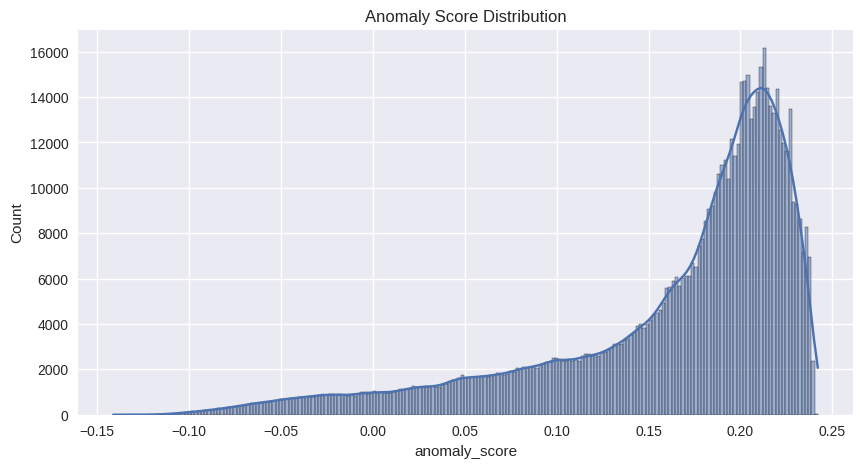

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(cleaned["anomaly_score"], kde=True)
plt.title("Anomaly Score Distribution")
plt.show()


In [20]:
cur.execute(
    "INSERT INTO logs (dataset_id, action, details) VALUES (?, ?, ?)",
    (dataset_id, "pipeline", "Pipeline completed successfully")
)
conn.commit()

print("Pipeline completed.")


Pipeline completed.
